# Varying Values of $c_1$ during Conductive Cooling: Nanoflare Trains
We've run the single- and two-fluid EBTEL models over a large parameter space of heating parameters. However, we did this using $c_1=c_{1,eq}=2$ for $n<n_{eq}$. We have now modified the prescription for $c_1$ such that,
$$
c_1 = \frac{2c_{1,eq} + c_{1,cond}((n_{eq}/n)^2-1)}{(n_{eq}/n)^2+1}
$$
for $n<n_{eq}$. We want to know whether changing the value of $c_1$ during the conductive cooling phase significantly alters the resulting emission measure. If they don't change significantly, there's no need to spend time re-running all of the results.

In [27]:
#import libraries
import sys,os
import xml.etree.ElementTree as ET
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('papers')
import seaborn.apionly as sns
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src'))
import ebtel_configure as ebc
import ebtel_run as ebr
import em_binner as emb
%matplotlib inline

Configure the base dictionary. None of these parameters should change. 

In [28]:
#configure inputs
config_dict = {'usage_option':'no_dem','rad_option':'rk','dem_option':'new','heat_flux_option':'limited',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 8e4
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'file'
config_dict['t_end_switch'] = 'file'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 2.5
config_dict['loop_length'] = 40.0
config_dict['t_pulse_half'] = 100
config_dict['sample_rate'] = 10
config_dict['output_file'] = 'ebtel_data/c1_nanoflare_train_tests'
#variable c1 options
config_dict['r3_grav_correction'] = 'True'
config_dict['r3_loss_correction'] = 'True'
config_dict['r3_rad_0'] = 0.6

Set some heating options.

In [29]:
delta_q = 10.0
time_averaged_heating_rate =  4.5e-3

Make a function to copy xml file to dictionary.

In [30]:
def xml_to_dict(config_file,config_dict):
    root = ET.parse(config_file).getroot()
    for child in root:
        if child.tag != 'output_file' and child.tag != 'heat_species':
            if child.tag == 'start_time_array' or child.tag == 'end_time_array' or child.tag == 'amp_array':
                temp = []
                for grandchild in child:
                    temp.append(float(grandchild.text))
                config_dict[child.tag] = temp
            else:
                try:
                    config_dict[child.tag] = float(child.text)
                except ValueError:
                    config_dict[child.tag] = child.text

Make a function to do the data collection.

In [31]:
def run_model(sf_run,tf_run,configurer,config_file=None):
    results = {'c':
               {'single':{},'electron':{},'ion':{}},
              'uc':
              {'single':{},'electron':{},'ion':{}}
              }
    #corrected
    configurer.config_dictionary['r3_cond_0'] = 6.0
    #single
    if config_file:
        xml_to_dict(config_file,configurer.config_dictionary)
    configurer.print_xml_config(config_file=configurer.config_dictionary['output_file']+'.xml')
    sf_run.run_ebtel_single(configurer.config_dictionary['output_file']+'.xml')
    data = np.loadtxt(configurer.config_dictionary['output_file']+'.txt')
    results['c']['single']['t'],results['c']['single']['Te'],results['c']['single']['n']= data[:,0],data[:,1],data[:,2]
    #electron
    configurer.config_dictionary['heat_species'] = 'electron'
    if config_file:
        xml_to_dict(config_file,configurer.config_dictionary)
    configurer.print_xml_config(config_file=configurer.config_dictionary['output_file']+'.xml')
    tf_run.run_ebtel_single(configurer.config_dictionary['output_file']+'.xml')
    data = np.loadtxt(configurer.config_dictionary['output_file']+'.txt')
    results['c']['electron']['t'],results['c']['electron']['Te'],results['c']['electron']['n'],results['q'] = data[:,0],data[:,1],data[:,3],data[:,15]
    #ion
    configurer.config_dictionary['heat_species'] = 'ion'
    if config_file:
        xml_to_dict(config_file,configurer.config_dictionary)
    configurer.print_xml_config(config_file=configurer.config_dictionary['output_file']+'.xml')
    tf_run.run_ebtel_single(configurer.config_dictionary['output_file']+'.xml')
    data = np.loadtxt(configurer.config_dictionary['output_file']+'.txt')
    results['c']['ion']['t'],results['c']['ion']['Te'],results['c']['ion']['n'] = data[:,0],data[:,1],data[:,3]
    #uncorrected
    configurer.config_dictionary['r3_cond_0'] = 2.0
    #single
    if config_file:
        xml_to_dict(config_file,configurer.config_dictionary)
    configurer.print_xml_config(config_file=configurer.config_dictionary['output_file']+'.xml')
    sf_run.run_ebtel_single(configurer.config_dictionary['output_file']+'.xml')
    data = np.loadtxt(configurer.config_dictionary['output_file']+'.txt')
    results['uc']['single']['t'],results['uc']['single']['Te'],results['uc']['single']['n'] = data[:,0],data[:,1],data[:,2]
    #electron
    configurer.config_dictionary['heat_species'] = 'electron'
    if config_file:
        xml_to_dict(config_file,configurer.config_dictionary)
    configurer.print_xml_config(config_file=configurer.config_dictionary['output_file']+'.xml')
    tf_run.run_ebtel_single(configurer.config_dictionary['output_file']+'.xml')
    data = np.loadtxt(configurer.config_dictionary['output_file']+'.txt')
    results['uc']['electron']['t'],results['uc']['electron']['Te'],results['uc']['electron']['n'] = data[:,0],data[:,1],data[:,3]
    #ion
    configurer.config_dictionary['heat_species'] = 'ion'
    if config_file:
        xml_to_dict(config_file,configurer.config_dictionary)
    configurer.print_xml_config(config_file=configurer.config_dictionary['output_file']+'.xml')
    tf_run.run_ebtel_single(configurer.config_dictionary['output_file']+'.xml')
    data = np.loadtxt(configurer.config_dictionary['output_file']+'.txt')
    results['uc']['ion']['t'],results['uc']['ion']['Te'],results['uc']['ion']['n'] = data[:,0],data[:,1],data[:,3]
    
    return results


Make runner instances.

In [32]:
sf_runner = ebr.Runner(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_C/bin/'),'')
tf_runner = ebr.Runner(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL-2fluid_repo/bin/'),'')

Plotting functions.

In [33]:
def plot_density(results):
    fig = plt.figure(figsize=(16,8))
    ax0 = plt.subplot2grid((3,2),(0,0))
    ax1 = plt.subplot2grid((3,2),(1,0),sharex=ax0)
    ax2 = plt.subplot2grid((3,2),(2,0),sharex=ax0)
    ax3 = plt.subplot2grid((3,2),(0,1),rowspan=3,sharex=ax0)
    #heating
    ax3.plot(results['c']['electron']['t'],results['q'],color='black',linestyle='solid')
    #corrected
    ax0.plot(results['c']['single']['t'],results['c']['single']['n']/1e+8,color=sns.color_palette('deep')[0])
    ax1.plot(results['c']['electron']['t'],results['c']['electron']['n']/1e+8,color=sns.color_palette('deep')[0])
    ax2.plot(results['c']['ion']['t'],results['c']['ion']['n']/1e+8,color=sns.color_palette('deep')[0],
              label=r'$\mathrm{corrected}$')
    #uncorrected
    ax0.plot(results['uc']['single']['t'],results['uc']['single']['n']/1e+8,color=sns.color_palette('deep')[2],linestyle='dashed')
    ax1.plot(results['uc']['electron']['t'],results['uc']['electron']['n']/1e+8,color=sns.color_palette('deep')[2],linestyle='dashed')
    ax2.plot(results['uc']['ion']['t'],results['uc']['ion']['n']/1e+8,color=sns.color_palette('deep')[2],linestyle='dashed',
               label=r'$\mathrm{uncorrected}$')
    #labels
    ax1.set_ylabel(r'$n\,\,(10^8\,\mathrm{cm}^{-3})$')
    ax2.set_xlabel(r'$t\,\,(\mathrm{s})$')
    ax3.set_ylabel(r'$H$')
    ax3.set_xlabel(r'$t\,\,(\mathrm{s})$')
    ax0.set_title(r'single')
    ax1.set_title(r'electron')
    ax2.set_title(r'ion')
    #limits
    ax3.set_ylim([0.,0.5])
    #legend
    ax2.legend(loc='best')
    #show
    plt.tight_layout()
    plt.show()

In [34]:
def plot_em(results):
    fig,axes = plt.subplots(1,3,figsize=(16,8),sharex=True,sharey=True)
    #corrected
    for ax,key in zip(axes,results['c']):
        #corrected
        binner = emb.EM_Binner(2.*config_dict['loop_length']*1e+8,time=results['c'][key]['t'],
                           temp=results['c'][key]['Te'],density=results['c'][key]['n'])
        binner.build_em_dist()
        hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
        ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[0],
           linestyle='solid',label=r'corrected')
        #uncorrected
        binner = emb.EM_Binner(2.*config_dict['loop_length']*1e+8,time=results['uc'][key]['t'],
                               temp=results['uc'][key]['Te'],density=results['uc'][key]['n'])
        binner.build_em_dist()
        hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
        ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[2],
           linestyle='dashed',label=r'uncorrected')
        ax.set_title(r'$\mathrm{%s}$'%(key))
            
    #labels,lims
    axes[0].legend(loc='best')
    axes[0].set_yscale('log')
    axes[0].set_xscale('log')
    axes[0].set_ylim([1.5e+25,2e+28])
    axes[0].set_xlim([10**5.5,10**7.5])
    axes[1].set_xlabel(r'$T\,\,\mathrm{(K)}$')
    axes[0].set_ylabel(r'$\mathrm{EM}\,\,(\mathrm{cm}^{-5})$')
    #show
    plt.show()

## Uniform Heating

Set up the uniform heating case.

In [35]:
config_maker = ebc.Configurer(config_dict,'',Hn=time_averaged_heating_rate)
config_maker.config_dictionary['amp_switch'] = 'uniform'

In [36]:
t_wait_mean = 250.0

### High-frequency heating, $t_N= $ 250 s

In [37]:
config_file = os.path.join('/data/datadrive2/EBTEL_runs/single_heating_runs/alpha%s/config/'%(str('uniform')),
'ebtel_L40.0_tn%d_tpulse200.0_rka4/ebtel_L40.0_tn%d_tpulse200.0_rka4_0.xml'%(t_wait_mean,t_wait_mean))

In [38]:
config_maker.config_dictionary['num_events'] = int(np.ceil(config_dict['total_time']/(2.0*config_dict['t_pulse_half'] + t_wait_mean)))
config_maker.amp_arrays(t_wait_mean)
config_maker.time_arrays(t_wait_mean)
uniform_results=run_model(sf_runner,tf_runner,config_maker,config_file=config_file)

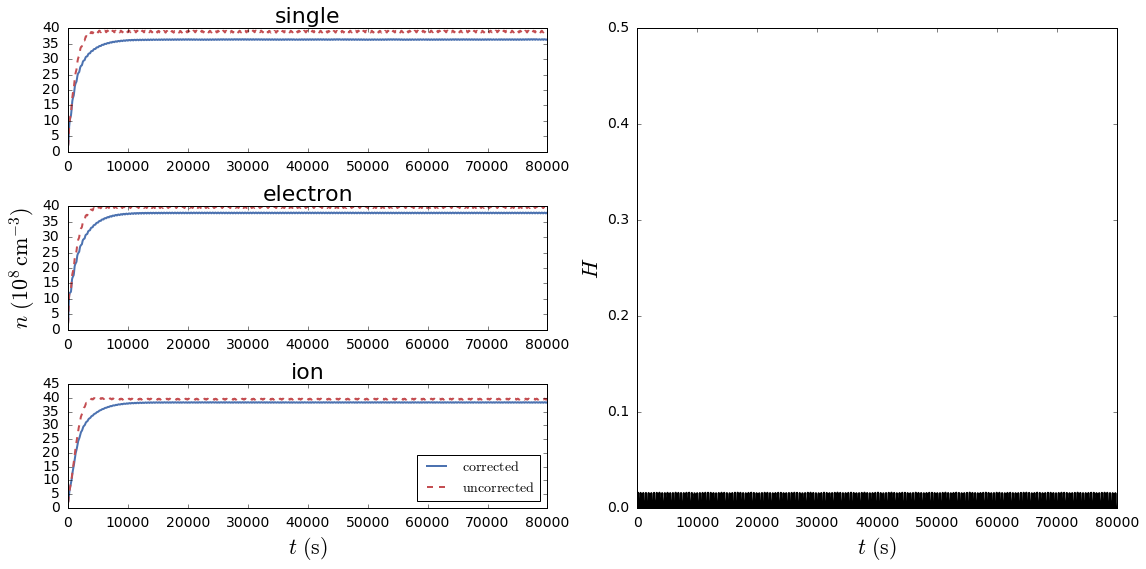

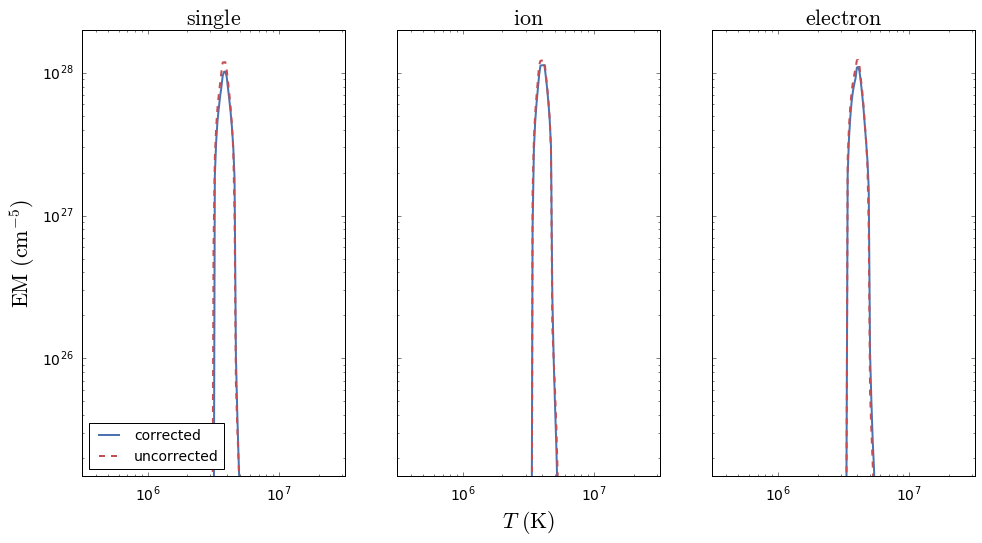

In [39]:
plot_density(uniform_results)
plot_em(uniform_results)

In [40]:
t_wait_mean = 5000.0

### Low-frequency Heating, $t_N=$ 5000 s

In [41]:
config_file = os.path.join('/data/datadrive2/EBTEL_runs/single_heating_runs/alpha%s/config/'%(str('uniform')),
'ebtel_L40.0_tn%d_tpulse200.0_rka4/ebtel_L40.0_tn%d_tpulse200.0_rka4_0.xml'%(t_wait_mean,t_wait_mean))

In [42]:
config_maker.config_dictionary['num_events'] = int(np.ceil(config_dict['total_time']/(2.0*config_dict['t_pulse_half'] + t_wait_mean)))
config_maker.amp_arrays(t_wait_mean)
config_maker.time_arrays(t_wait_mean)
uniform_results=run_model(sf_runner,tf_runner,config_maker,config_file=config_file)

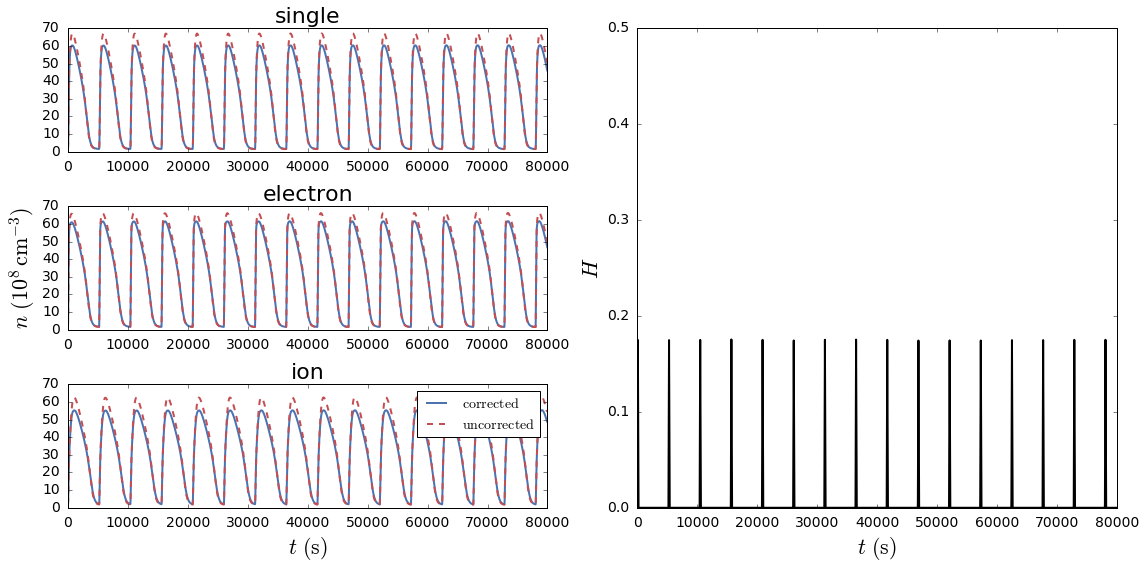

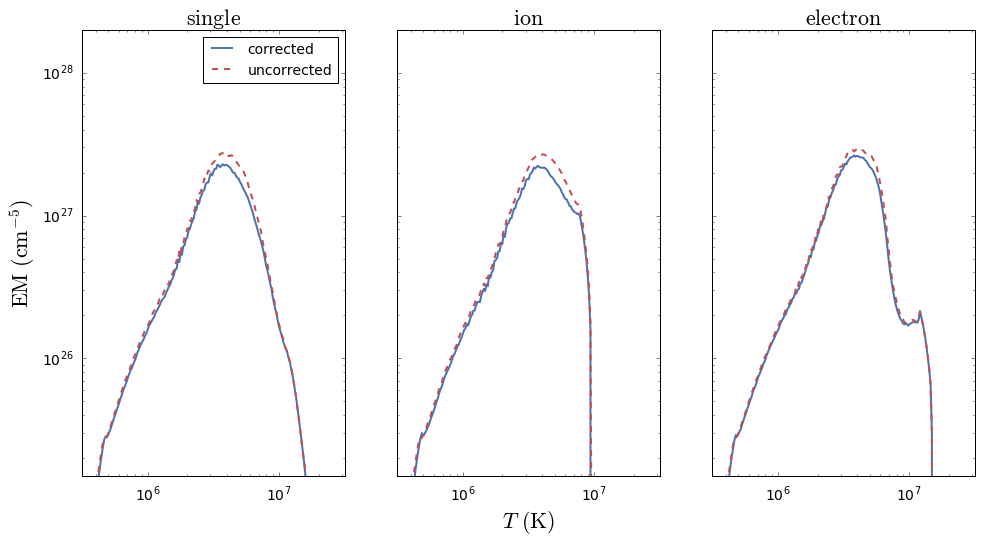

In [43]:
plot_density(uniform_results)
plot_em(uniform_results)

## Power-law Heating, $\beta=1$
Set up the power-law case

In [44]:
config_maker = ebc.Configurer(config_dict,'',t_wait_q_scaling=1.0,Hn=time_averaged_heating_rate,delta_q=delta_q)
config_maker.config_dictionary['amp_switch'] = 'file'

In [45]:
t_wait_mean=750.0

### High-frequency Heating, $t_N=$ 750 s

In [46]:
config_file = os.path.join('/data/datadrive2/EBTEL_runs/single_heating_runs/alpha%s/config/'%(str(2.5)),
'ebtel_L40.0_tn%d-b1.0_tpulse200.0_rka4/ebtel_L40.0_tn%d-b1.0_tpulse200.0_rka4_0.xml'%(t_wait_mean,t_wait_mean))

In [47]:
config_maker.config_dictionary['num_events'] = int(np.ceil(config_dict['total_time']/(2.0*config_dict['t_pulse_half'] + t_wait_mean)))
config_maker.amp_arrays(t_wait_mean)
config_maker.time_arrays(t_wait_mean)
power_law_results = run_model(sf_runner,tf_runner,config_maker,config_file=config_file)

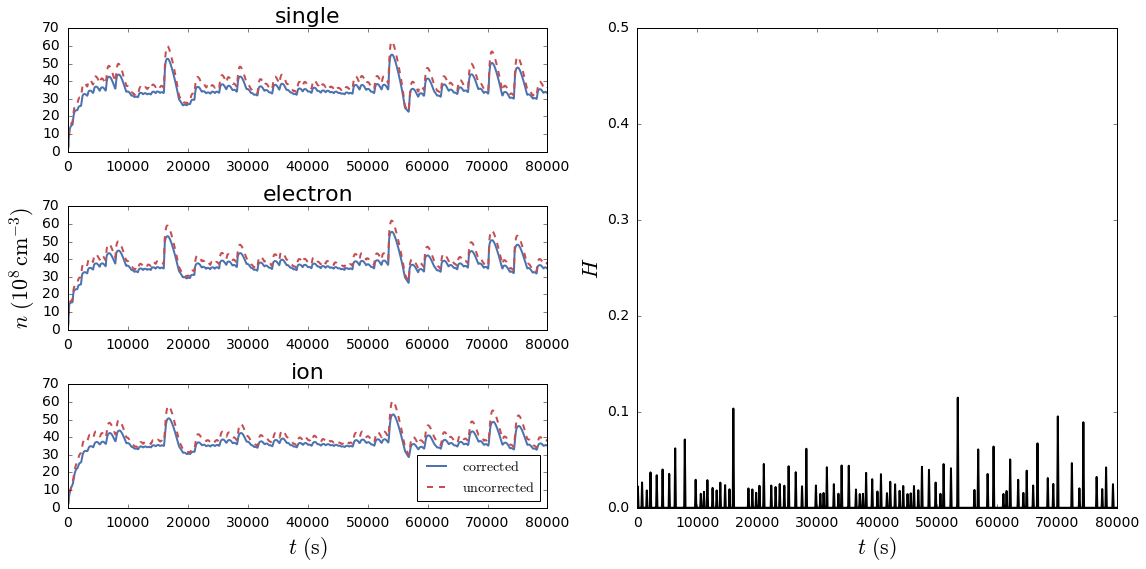

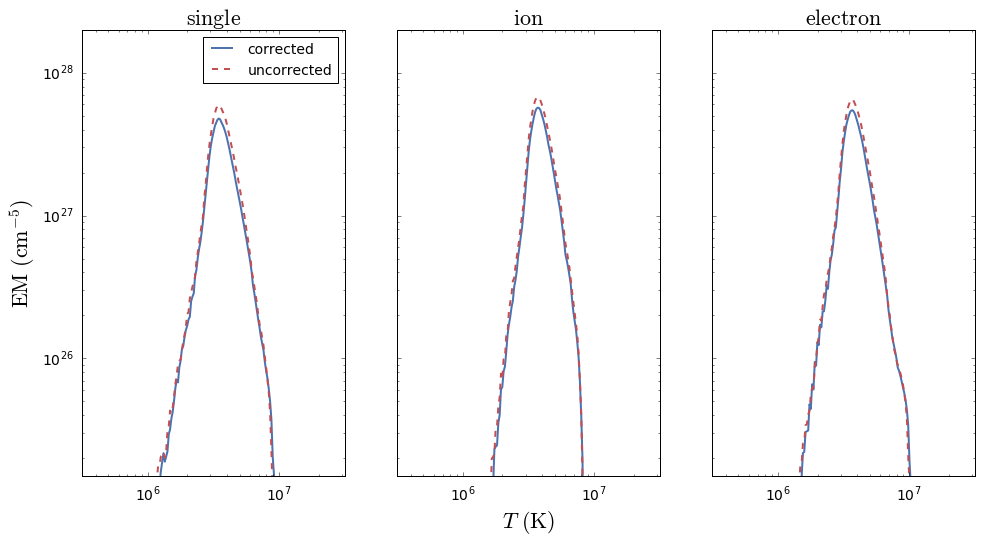

In [48]:
plot_density(power_law_results)
plot_em(power_law_results)

In [49]:
t_wait_mean = 4000.0

### Low-frequency Heating, $t_N=$ 4000 s

In [50]:
config_file = os.path.join('/data/datadrive2/EBTEL_runs/single_heating_runs/alpha%s/config/'%(str(2.5)),
'ebtel_L40.0_tn%d-b1.0_tpulse200.0_rka4/ebtel_L40.0_tn%d-b1.0_tpulse200.0_rka4_0.xml'%(t_wait_mean,t_wait_mean))

In [51]:
config_maker.config_dictionary['num_events'] = int(np.ceil(config_dict['total_time']/(2.0*config_dict['t_pulse_half'] + t_wait_mean)))
config_maker.amp_arrays(t_wait_mean)
config_maker.time_arrays(t_wait_mean)
power_law_results = run_model(sf_runner,tf_runner,config_maker,config_file=config_file)

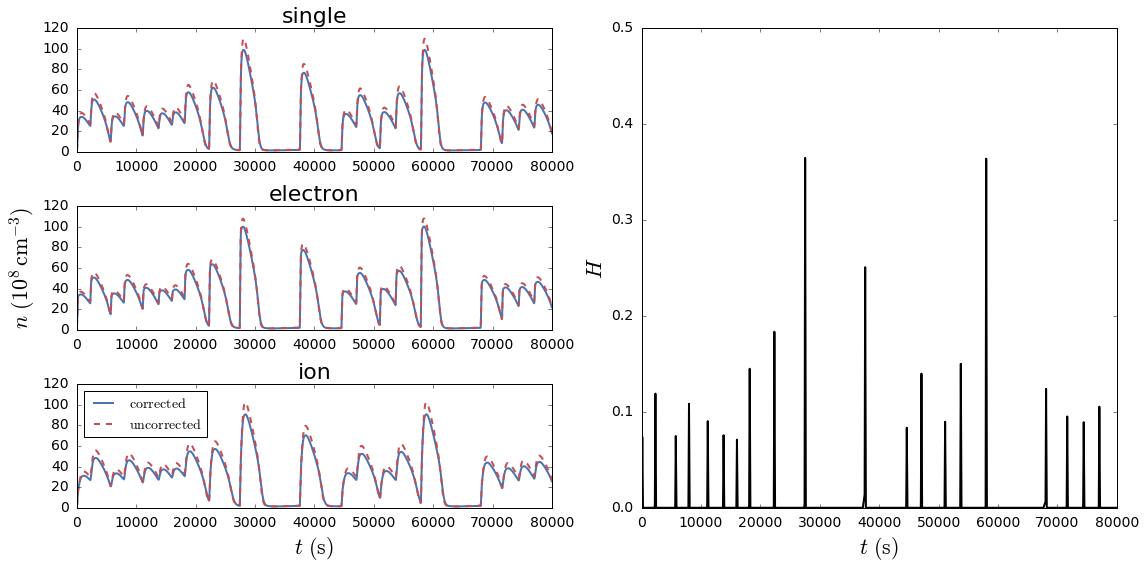

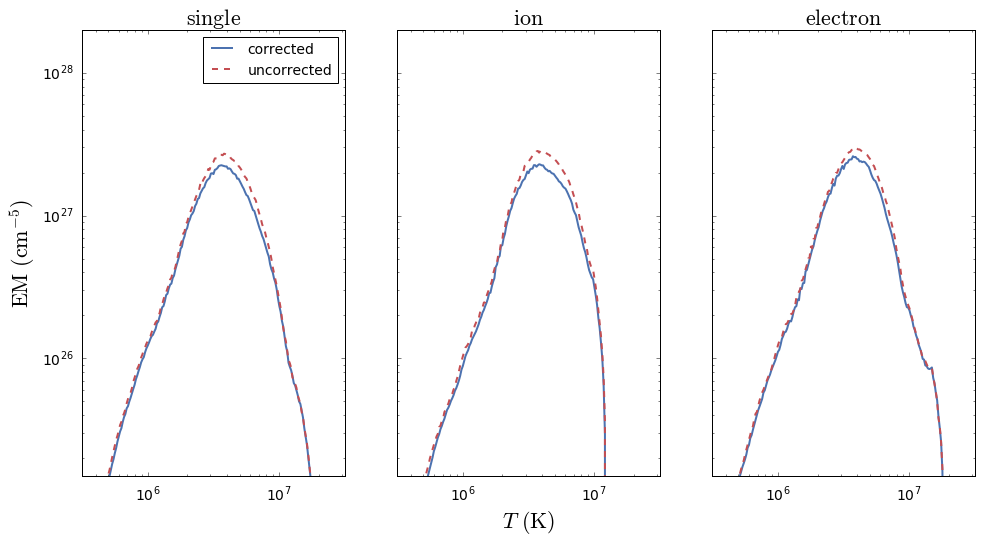

In [52]:
plot_density(power_law_results)
plot_em(power_law_results)

So using a conductive value of $c_{1,cond}=6$ seems to give a more power-law-like emission measure on the hot side, though it is hard to draw too many conclusions from just a few runs when our heating function is determined by a power-law. 

$\mathrm{EM}(T)$ near the peak is reduced and drops off a bit faster. There is essentially no difference for $T>10^7$ K. 

The nanoflare train runs will be computed again to account for this effect and also because previous values of $c_2$ that were used are not correct and yield quite different results on the cool side.